In [37]:
import numpy as np
from operator import add
from random import shuffle, sample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [52]:
def vsigmoid(Z: np.ndarray) -> np.ndarray:
    '''Z can be a Numpy array of any shape; 2D in the case of this application'''
    return 1/(1 + np.exp(-Z))

def softmax(Z: np.ndarray) -> np.ndarray:
    '''Z is a 1D Numpy array'''
    return np.exp(Z)/np.sum(np.exp(Z))

class Input:
    def __init__(self, X, W, b):
        '''X.shape = (n, d), n number of samples; d number of features
           W.shape = (d, h), h number of neurons in the hidden layer
           b.shape = (1, h), when b is added to X @ W, b will be broadcasted into shape (n, h)'''
        self.X = X
        self.W = W
        self.b = b
       
    def to_hidden(self):
        return self.X @ self.W + self.b

class Hidden:
    def __init__(self, Z, W, b):
        '''Z.shape = (n, h)
           W.shape = (h, c), c number of classes
           b.shape = (1, c), will also be broadcasted into shape (n, c)'''
        self.Z = Z # Hidden.Z is the pre-activation output of the Input layer, i.e., Hidden.Z = Input.X @ Input.W + Input.b
        self.W = W
        self.b = b

    def activation(self):
        return vsigmoid(self.Z)

    def to_output(self, A): # A is the post-activation output of the hidden layer, i.e., A = vsigmoid(Hidden.Z)
        return A @ self.W + self.b

class Output:
    def __init__(self, Z):
        '''Z.shape = (n, c)'''
        self.Z = Z # Output.Z is the pre-activation output of the Hidden layer, i.e., A @ Hidden.W + Hidden.b, where A = vsigmoid(Hidden.Z)

    def activation(self):
        return np.apply_along_axis(softmax, 1, self.Z)
        
def adam(alpha, beta1, beta2, epsilon, theta, g, m, v, t):
    '''alpha, beta1, beta2, epsilon are hyperparameters; all hyperparameters should be passed as floats
       theta is the parameter to be updated with the algorithm
       g: gradient of theta'''   
    m = beta1 * m + (1 - beta1) * g
    v = beta2 * v + (1 - beta2) * (g ** 2)
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    theta = theta - alpha * m_hat / (np.sqrt(v_hat) + epsilon)  
    return m, v, theta

def loss_func(Y: np.ndarray, A: np.ndarray, a_min=1e-4) -> float:
    '''Y.shape = (n, d), Y is the correct label array
       A.shape = (n, d), A is the output probability array at the output layer
    '''
    A_clipped = np.clip(A, a_min=a_min, a_max=1.0)
    return np.mean(-np.sum(Y*np.log(A_clipped), axis=1))


class Network:
    def __init__(self, X, Y, W2, b2, W1, b1):
        self.X = X
        self.Y = Y
        self.W2 = W2
        self.b2 = b2
        self.W1 = W1
        self.b1 = b1

    def forward(self, batch, W2, b2, W1, b1):
        input_layer = Input(batch, W1, b1)
        Z1 = input_layer.to_hidden()
        hidden_layer = Hidden(Z1, W2, b2)
        A1 = hidden_layer.activation()
        Z2 = hidden_layer.to_output(A1)
        output_layer = Output(Z2)
        A2 = output_layer.activation()
        return A1, A2

    def train(self, alpha, beta1, beta2, epsilon, batch_size, p=0, max_epochs=500, threshold=1e-4):  
        N = int(self.X.shape[0] / batch_size) # number of batches
        params = [self.W2, self.b2, self.W1, self.b1]
        means = [np.zeros_like(self.W2), np.zeros_like(self.b2), np.zeros_like(self.W1), np.zeros_like(self.b1)]
        variances = [np.zeros_like(self.W2), np.zeros_like(self.b2), np.zeros_like(self.W1), np.zeros_like(self.b1)]

        t, loss_pre = 1, float('inf')
        losses = [] # track loss history

        for epoch in range(max_epochs):
            # shuffle dataset in mini-batches
            XY = list(zip(
            [self.X[_*batch_size:(_+1)*batch_size] for _ in range(N)],
            [self.Y[_*batch_size:(_+1)*batch_size] for _ in range(N)]
            ))
            shuffle(XY)

            loss = 0
            gradients = [np.zeros_like(self.W2), np.zeros_like(self.b2), np.zeros_like(self.W1), np.zeros_like(self.b1)]
        
            for batch, label in XY:
                A1, A2 = self.forward(batch, params[0], params[1], params[2], params[3])

                # this part does the dropout
                h = A1.shape[1]
                num = int(h * p)
                if num > 0:
                    to_drop = sorted(sample(range(h), num))
                    mask = np.ones_like(A1)
                    mask[:, to_drop] = 0
                    A1 *= mask  
                    A1 *= 1 / (1 - p)

                loss += loss_func(label, A2)

                partial_Z2 = A2 - label
                partial_W2 = A1.T @ partial_Z2
                partial_b2 = np.mean(partial_Z2, axis=0, keepdims=True)
                partial_A1 = partial_Z2 @ params[0].T
                partial_Z1 = partial_A1 * (A1 * (1 - A1))
                partial_W1 = batch.T @ partial_Z1
                partial_b1 = np.mean(partial_Z1, axis=0, keepdims=True)

                gradients = list(map(add, gradients, [partial_W2, partial_b2, partial_W1, partial_b1]))

                t += 1

            # average across batches
            loss = loss / N
            losses.append(loss) # <-- record epoch loss

            if abs(loss - loss_pre) < threshold:
                break
            loss_pre = loss

            gradients = list(map(lambda x: x / N, gradients))
            for i, param in enumerate(params):
                means[i], variances[i], params[i] = adam(alpha, beta1, beta2, epsilon, param,
                                                         gradients[i], means[i], variances[i], t)

        W2_hat, b2_hat, W1_hat, b1_hat = params
        return W2_hat, b2_hat, W1_hat, b1_hat, losses 

    def predict(self, test_data, W2_hat, b2_hat, W1_hat, b1_hat):
        A1, A2 = self.forward(test_data, W2_hat, b2_hat, W1_hat, b1_hat)
        argmax_indices = np.argmax(A2, axis=1)
        y_hat = np.zeros_like(A2)
        y_hat[[_ for _ in range(len(A2))], list(argmax_indices)] = 1
        return y_hat

    def score_accuracy(self, y_hat, y_test):
        argmax_hat, argmax_test = np.argmax(y_hat, axis=1), np.argmax(y_test, axis=1)
        return list(argmax_hat == argmax_test).count(True)/len(y_test)

    def plot_loss(self, losses):
        plt.plot(range(len(losses)), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.show()

    def plot_confusion(self, y_hat, y_test):
        cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_hat, axis=1))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.show()

In [53]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [54]:
iris = load_iris()
X, y = iris.data, iris.target
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0))/np.std(X_test, axis=0)

print(X_train.shape, y_train.shape)

(120, 4) (120, 3)


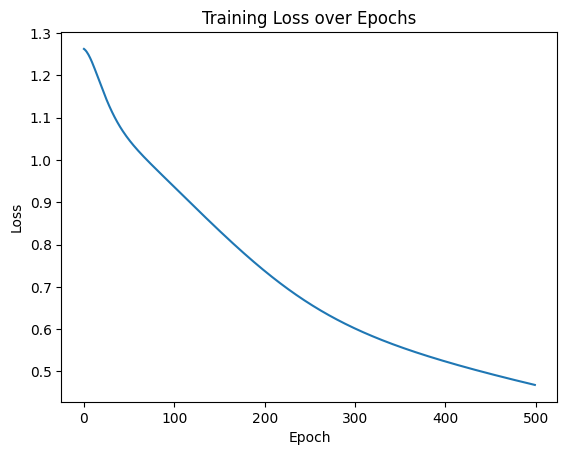

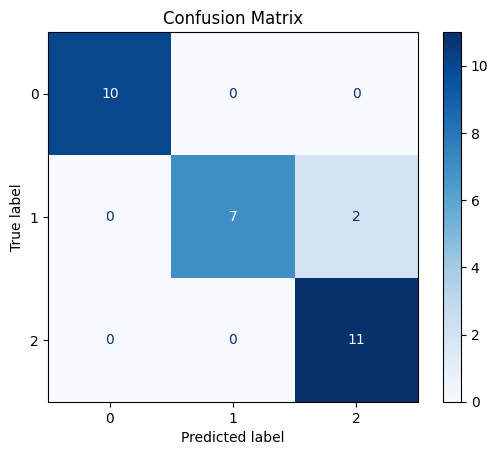


Accuracy = 0.9333333333333333


In [55]:
n, d, h, c, batch_size = 120, 4, 6, 3, 20
W2, b2, W1, b1 = np.random.rand(h,c), np.random.rand(1,c), np.random.rand(d,h), np.random.rand(1,h)

alpha, beta1, beta2, epsilon = 0.001, 0.9, 0.999, 1e-7
network = Network(X_train, y_train, W2, b2, W1, b1)
W2_hat, b2_hat, W1_hat, b1_hat, losses = network.train(alpha, beta1, beta2, epsilon, batch_size, p=0.1)

y_hat = network.predict(X_test, W2_hat, b2_hat, W1_hat, b1_hat)
network.plot_loss(losses) 
network.plot_confusion(y_hat, y_test)
accuracy = network.score_accuracy(y_hat, y_test)
print(f'\nAccuracy = {accuracy}')

In [56]:
from sklearn.datasets import load_wine
wine = load_wine()
X, y = wine.data, wine.target
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0))/np.std(X_test, axis=0)

print(X_train.shape, y_train.shape)

(142, 13) (142, 3)


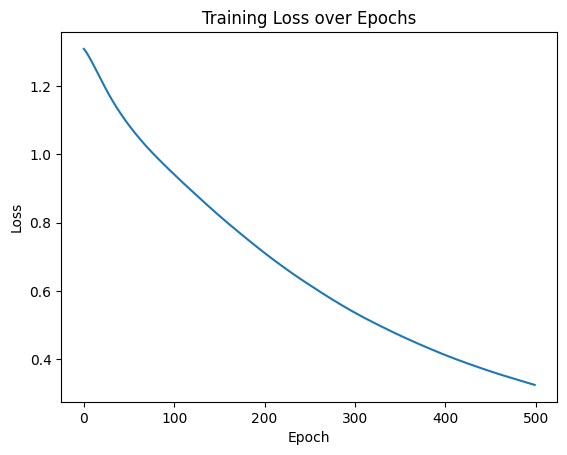

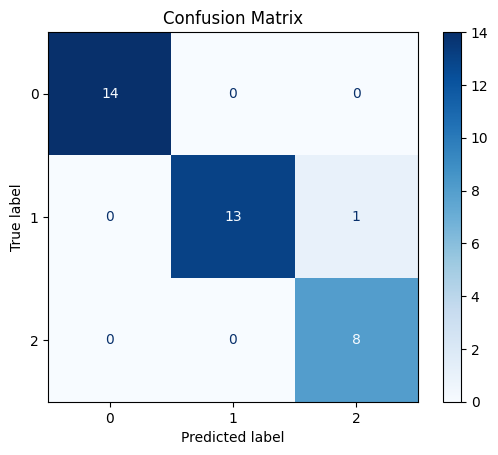

Accuracy = 0.9722222222222222


In [58]:
n, d, h, c, batch_size = 142, 13, 12, 3, 71
W2, b2, W1, b1 = np.random.rand(h,c), np.random.rand(1,c), np.random.rand(d,h), np.random.rand(1,h)

alpha, beta1, beta2, epsilon = 0.001, 0.9, 0.999, 1e-7
network = Network(X_train, y_train, W2, b2, W1, b1)
W2_hat, b2_hat, W1_hat, b1_hat, losses = network.train(alpha, beta1, beta2, epsilon, batch_size, p=0.2)

y_hat = network.predict(X_test, W2_hat, b2_hat, W1_hat, b1_hat)
network.plot_loss(losses) 
network.plot_confusion(y_hat, y_test)
accuracy = network.score_accuracy(y_hat, y_test)
print(f'Accuracy = {accuracy}')